In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip
/kaggle/input/fontss/Agdasima-Bold.ttf
/kaggle/input/fontss/Agdasima-Regular.ttf
/kaggle/input/fontss/OFL.txt


# Import Libaries

In [2]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=35acd1a6aa02ac618407e9c077b6cced3df87ad50738415d6d4cb0578b39773e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=2dc92fc74b569b828a8b33464d3aea98c2fae9ae8259cfd1601a60fe39e49aaf
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
!pip install adabound
from adabound import AdaBound

In [24]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image

In [23]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils

# Config

In [6]:
batch_size = 4
n_iters = 100
epochs = 50
learning_rate = 0.0001
n_workers = 2


width = 256
height = 256
channels = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 44
random.seed(seed)
torch.manual_seed(seed)

In [7]:
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    split_pct = 0.2
    split_pct1 = 0.1
    learning_rate = 0.0002
    batch_size = 4
    epochs = 50

# Load Data

In [8]:
# extract train data
with ZipFile('../input/carvana-image-masking-challenge/train.zip', 'r') as zf:
    zf.extractall('../working')
     
with ZipFile('../input/carvana-image-masking-challenge/train_masks.zip', 'r') as zf:
    zf.extractall('../working')

In [9]:
 class MyDataset(Dataset):
    def __init__(self, root_dir: str, train=True, transforms=None):
        super(MyDataset, self).__init__()
        self.train = train
        self.transforms = transforms
        
        file_path = root_dir + 'train/*.*'
        file_mask_path = root_dir + 'train_masks/*.*'
        
        self.images = sorted(glob(file_path))
        self.image_mask = sorted(glob(file_mask_path))
        
        # manually split the train/valid data
        split_ratio = int(len(self.images) * 0.8)
        if train:
            self.images = self.images[:split_ratio]
            self.image_mask = self.image_mask[:split_ratio]
        else:
            self.images = self.images[split_ratio:]
            self.image_mask = self.image_mask[split_ratio:]
        
        
    def __getitem__(self, index: int):
        image = Image.open(self.images[index]).convert('RGB')
        image_mask = Image.open(self.image_mask[index]).convert('L')

        
        if self.transforms:
            image = self.transforms(image)
            image_mask = self.transforms(image_mask)
                        
        return {'img': image, 'mask': image_mask}
    
    def __len__(self):
        return len(self.images)
    

transforms = T.Compose([
    T.Resize((width, height)),
    T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
#     T.RandomHorizontalFlip()
])
train_dataset = MyDataset(root_dir='../working/',
                                 train=True,
                                 transforms=transforms)
val_dataset = MyDataset(root_dir='../working/',
                                train=False,
                                transforms=transforms)

"""train_dataset_loader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=n_workers)
val_dataset_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=n_workers)"""

        

'train_dataset_loader = DataLoader(dataset=train_dataset,\n                                batch_size=batch_size,\n                                shuffle=True,\n                                num_workers=n_workers)\nval_dataset_loader = DataLoader(dataset=val_dataset,\n                               batch_size=batch_size,\n                               shuffle=False,\n                               num_workers=n_workers)'

In [10]:
import numpy as np

# Assuming the original validation dataset contains 20% of the total data
val_length = len(val_dataset)
test_length = val_length // 2
val_length = val_length - test_length

# Split the validation dataset into validation and test datasets
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [val_length, test_length])

# Now you have three datasets: train_dataset, val_dataset, and test_dataset
# The train_dataset contains 80% of the data, the val_dataset contains 10%, and the test_dataset contains 10%.

# You can then create DataLoader objects for each dataset as needed.
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=n_workers)
val_dataset_loader = DataLoader(dataset=val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=n_workers)
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=n_workers)

# Sample Data

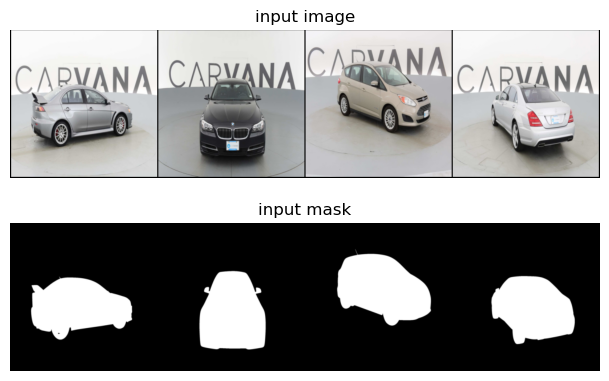

In [11]:
samples = next(iter(train_dataset_loader))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
fig.tight_layout()


ax1.axis('off')
ax1.set_title('input image')
ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                       (1, 2, 0)))

ax2.axis('off')
ax2.set_title('input mask')
ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                       (1, 2, 0)), cmap='gray')

plt.show()

# ARCHITECTURE

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, dilation=1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, dilation=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class TransUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(TransUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64, dilation=2)  # Set dilation=2 for the first convolutional layer

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)

        logits = self.outc(x9)
        logits = torch.sigmoid(logits)
        return logits


# Metrics

In [13]:
def dice_score(pred: torch.Tensor, mask: torch.Tensor):
    dice = (2 * (pred * mask).sum()) / (pred + mask).sum()
    return (dice.cpu().numpy())

from torchmetrics import JaccardIndex
jaccard = JaccardIndex(task='binary', num_classes=2).to(CFG.device)

from torchmetrics.classification import BinaryAccuracy
train_accuracy = BinaryAccuracy().to(CFG.device)
valid_accuracy = BinaryAccuracy().to(CFG.device)
test_accuracy = BinaryAccuracy().to(CFG.device)

from torchmetrics.classification import BinaryRecall
metric = BinaryRecall().to(CFG.device)

from torchmetrics.classification import BinaryPrecision
metric1 = BinaryPrecision().to(CFG.device)

from torchmetrics.classification import BinarySpecificity
metric2 = BinarySpecificity().to(CFG.device)

In [14]:
class BestMetric:
    def __init__(self):
        self.best_value = float('-inf')
    
    def update(self, value):
        if value > self.best_value:
            self.best_value = value
        return self.best_value
    
    def reset(self):
        self.best_value = float('-inf')
    
    def get_best(self):
        return self.best_value

# Plotting

In [15]:
def plot_pred_img(samples, pred):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
    fig.tight_layout()


    ax1.axis('off')
    ax1.set_title('input image')
    ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                           (1, 2, 0)))

    ax2.axis('off')
    ax2.set_title('input mask')
    ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                           (1, 2, 0)), cmap='gray')
    
    ax3.axis('off')
    ax3.set_title('predicted mask')
    ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(),
                           (1, 2, 0)), cmap='gray')

    plt.show()
    
    
def plot_train_progress_A(model):
#     model.eval()

#     with torch.no_grad():
    samples = next(iter(val_dataset_loader))
    val_img = samples['img'].to(device)
    val_mask = samples['mask'].to(device)

    pred = model(val_img)

    plot_pred_img(samples, pred.detach())

In [16]:
def plot_train_progress(epoch, model, samples, pred):
    if epoch == 40:
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
        fig.tight_layout()

        ax1.axis('off')
        ax1.set_title('input image')
        ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                                (1, 2, 0)))

        ax2.axis('off')
        ax2.set_title('input mask')
        ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                                (1, 2, 0)), cmap='gray')

        ax3.axis('off')
        ax3.set_title('predicted mask')
        ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(),
                                (1, 2, 0)), cmap='gray')

        plt.show()

# LOSS FUNCTION

In [17]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True, gamma = 0.2, beta = 0.8):
        super(DiceBCELoss, self).__init__()
        self.gamma = gamma
        self.beta = beta

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE_with_Logits = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        Dice_BCE = BCE_with_Logits + dice_loss
        
        dice_loss = self.beta * dice_loss
        BCE_with_Logits = self.gamma * BCE_with_Logits

        Dice_BCE = BCE_with_Logits + dice_loss

        
        return Dice_BCE

# Train

In [18]:
def train(model, optimizer, criterion, scheduler=None, CFG=CFG):
    train_losses = []
    val_losses = []
    train_accs = []
    valid_accs = []
    dice_scores = []  # List to store Dice coefficients
    lr_rates = []

    best_metric1 = BestMetric()
    best_metric2 = BestMetric()
    best_metric3 = BestMetric()
    best_metric4 = BestMetric()
    best_metric5 = BestMetric()

    for epoch in range(CFG.epochs):
        model.train()
        train_total_loss = 0
        train_iterations = 0
        train_acc_total = 0

        for idx, data in enumerate(tqdm(train_dataset_loader)):
            train_iterations += 1
            train_img = data['img'].to(device)
            train_mask = data['mask'].to(device)
            threshold = 0.5
            train_mask1 = (train_mask >= threshold).float()

            optimizer.zero_grad()
            with torch.autocast(device_type='cuda'):
                train_output_mask = model(train_img)
                train_loss = criterion(train_output_mask, train_mask)
                train_total_loss += train_loss.item()
                train_acc_total += train_accuracy(train_output_mask, train_mask1)

            train_loss.backward()
            optimizer.step()

        train_epoch_loss = train_total_loss / train_iterations
        train_acc = train_acc_total / train_iterations
        train_losses.append(train_epoch_loss)
        train_accs.append(train_acc)

        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_iterations = 0
            total_valid_acc = 0
            scores = 0
            jaccard_scores = 0  # New variable to accumulate Jaccard scores
            metric_scores = 0
            metric1_scores = 0
            metric2_scores = 0

            for vidx, val_data in enumerate(tqdm(val_dataset_loader)):
                val_iterations += 1
                val_img = val_data['img'].to(device)
                val_mask = val_data['mask'].to(device)
                threshold = 0.5
                val_mask1 = (val_mask >= threshold).float()

                with torch.no_grad():
                    pred = model(val_img)
                    # Ensure the predictions and target tensors have the same shape
                    pred = pred[:, 0:1, :, :]

                    val_loss = criterion(pred, val_mask)
                    val_total_loss += val_loss.item()
                    total_valid_acc += valid_accuracy(pred, val_mask1)
                    scores += dice_score(pred, val_mask)
                    jaccard_scores += jaccard(pred, val_mask1) # Accumulate Jaccard scores
                    metric_scores += metric(pred, val_mask1)
                    metric1_scores += metric1(pred, val_mask1)
                    metric2_scores += metric2(pred, val_mask1)
            
            val_epoch_loss = val_total_loss / val_iterations
            val_acc = total_valid_acc / val_iterations
            val_losses.append(val_epoch_loss)
            valid_accs.append(val_acc)
            dice_coef_score = scores / val_iterations
            dice_scores.append(dice_coef_score)  # Store Dice coefficient
            jaccard_score = jaccard_scores / val_iterations  # Average Jaccard index
            metric_score = metric_scores / val_iterations
            metric1_score = metric1_scores / val_iterations
            metric2_score = metric2_scores / val_iterations 

            best_metric1.update(dice_coef_score)
            best_metric2.update(jaccard_score)
            best_metric3.update(metric1(pred, val_mask1))
            best_metric4.update(train_acc)
            best_metric5.update(val_acc)

            if epoch == 40:
                samples = next(iter(val_dataset_loader))
                val_img = samples['img'].to(CFG.device)
                val_mask = samples['mask'].to(CFG.device)
                pred = model(val_img)
                plot_train_progress(epoch, model, samples, pred.detach())

            print('epochs - {}/{} [{}/{}], dice score: {}, train loss: {}, val loss: {}, iou score:{}, train_accuracy:{}, valid_accuracy:{}, Recall:{}, Precision:{}, Specificity:{}'.format(
                epoch+1, CFG.epochs,
                idx+1, len(train_dataset_loader),
                dice_coef_score, train_epoch_loss, val_epoch_loss, jaccard_score, train_acc, val_acc, metric_score, metric1_score, metric2_score 
            ))

        lr_rates.append(optimizer.param_groups[0]['lr'])
        if scheduler:
            scheduler.step()

    best_DiceScore = best_metric1.get_best()
    best_IoUscore = best_metric2.get_best()
    best_precision = best_metric3.get_best()
    best_TrainAcc = best_metric4.get_best()
    best_ValidAcc = best_metric5.get_best()
    print('Best Dice Score: {:.4f}'.format(best_DiceScore))
    print('Best IoU Score: {:.4f}'.format(best_IoUscore))
    print('Best Precision: {:.4f}'.format(best_precision))
    print('Best Train Accuracy: {:.4f}'.format(best_TrainAcc))
    print('Best Valid Accuracy: {:.4f}'.format(best_ValidAcc))

    return {
        'lr': lr_rates,
        'train_loss': train_losses,
        'valid_loss': val_losses,
        'train_acc': train_accs,
        'valid_acc': valid_accs,
        'dice_scores': dice_scores  # Include dice scores in the returned dictionary
    }

In [19]:
model = TransUNet(n_channels=3, n_classes=1).to(device)
#criterion = nn.BCEWithLogitsLoss()
# criterion = smp.losses.DiceLoss(mode='binary')
criterion = DiceBCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.Adamax(model.parameters(), lr=0.0002)
optimizer = AdaBound(model.parameters(), lr=0.002, final_lr=0.1)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

In [20]:
val_img = samples['img'].to(CFG.device)
pred = model(val_img)
pred

tensor([[[[0.4605, 0.2645, 0.2651,  ..., 0.3582, 0.2452, 0.4300],
          [0.4786, 0.6014, 0.5320,  ..., 0.4533, 0.5070, 0.6078],
          [0.4966, 0.7424, 0.5513,  ..., 0.4929, 0.5838, 0.4314],
          ...,
          [0.5651, 0.1415, 0.5565,  ..., 0.3697, 0.4268, 0.4880],
          [0.2869, 0.1559, 0.4648,  ..., 0.3561, 0.5287, 0.6767],
          [0.3487, 0.4618, 0.4855,  ..., 0.3795, 0.5777, 0.5392]]],


        [[[0.4822, 0.2731, 0.2852,  ..., 0.3583, 0.2591, 0.4583],
          [0.4658, 0.5779, 0.5109,  ..., 0.5038, 0.5227, 0.6237],
          [0.4850, 0.6791, 0.5134,  ..., 0.5474, 0.6021, 0.4251],
          ...,
          [0.5308, 0.1326, 0.4886,  ..., 0.3504, 0.4231, 0.5609],
          [0.2841, 0.1595, 0.4437,  ..., 0.3247, 0.4640, 0.6832],
          [0.3702, 0.4469, 0.4999,  ..., 0.3141, 0.5380, 0.5308]]],


        [[[0.4692, 0.2741, 0.2936,  ..., 0.3802, 0.2683, 0.4440],
          [0.4808, 0.5865, 0.5471,  ..., 0.4855, 0.4952, 0.6158],
          [0.5066, 0.7172, 0.5280,  ..

100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


epochs - 1/50 [1018/1018], dice score: 0.8927278215996921, train loss: 0.17046202328385446, val loss: 0.21451795345637947, iou score:0.8107749819755554, train_accuracy:0.9782006740570068, valid_accuracy:0.9508521556854248, Recall:0.9910839200019836, Precision:0.8167386651039124, Specificity:0.9399958252906799


100%|██████████| 128/128 [00:21<00:00,  5.94it/s]


epochs - 2/50 [1018/1018], dice score: 0.9627530165016651, train loss: 0.15483424272424814, val loss: 0.15393038850743324, iou score:0.9348616003990173, train_accuracy:0.98545241355896, valid_accuracy:0.9859713315963745, Recall:0.9612212181091309, Precision:0.9715433716773987, Specificity:0.9925380945205688


100%|██████████| 128/128 [00:21<00:00,  5.93it/s]


epochs - 3/50 [1018/1018], dice score: 0.8456986849196255, train loss: 0.1496724043853859, val loss: 0.2551603924948722, iou score:0.7383249998092651, train_accuracy:0.9879456162452698, valid_accuracy:0.9250143766403198, Recall:0.9826943874359131, Precision:0.7483685612678528, Specificity:0.9099412560462952


100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


epochs - 4/50 [1018/1018], dice score: 0.8763758838176727, train loss: 0.14737920742664917, val loss: 0.22865696891676635, iou score:0.785673201084137, train_accuracy:0.9890555739402771, valid_accuracy:0.9419084787368774, Recall:0.9908072352409363, Precision:0.7915451526641846, Specificity:0.9290949106216431


100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


epochs - 5/50 [1018/1018], dice score: 0.9735734616406262, train loss: 0.14577077987854514, val loss: 0.14495779969729483, iou score:0.9544566869735718, train_accuracy:0.989870548248291, valid_accuracy:0.9901421070098877, Recall:0.9816036224365234, Precision:0.9718794822692871, Specificity:0.9923741221427917


100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


epochs - 6/50 [1018/1018], dice score: 0.9680938571691513, train loss: 0.14454434342199318, val loss: 0.14934427221305668, iou score:0.9451811909675598, train_accuracy:0.990452766418457, valid_accuracy:0.9883607625961304, Recall:0.9576869606971741, Precision:0.9864057302474976, Specificity:0.9964951276779175


100%|██████████| 128/128 [00:22<00:00,  5.74it/s]


epochs - 7/50 [1018/1018], dice score: 0.9751163423061371, train loss: 0.14378125725537247, val loss: 0.1436954375822097, iou score:0.9575096368789673, train_accuracy:0.9908775687217712, valid_accuracy:0.9908307790756226, Recall:0.9862710237503052, Precision:0.9704650044441223, Specificity:0.99201899766922


100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


epochs - 8/50 [1018/1018], dice score: 0.9695221483707428, train loss: 0.1424317661753338, val loss: 0.14814404642675072, iou score:0.9473947286605835, train_accuracy:0.9915254712104797, valid_accuracy:0.98884117603302, Recall:0.9591975212097168, Precision:0.98722904920578, Specificity:0.9966844916343689


100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


epochs - 9/50 [1018/1018], dice score: 0.9581234352663159, train loss: 0.14168485403353667, val loss: 0.15807039197534323, iou score:0.9254311323165894, train_accuracy:0.9918518662452698, valid_accuracy:0.9834479689598083, Recall:0.9767462611198425, Precision:0.9463602900505066, Specificity:0.985274612903595


100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


epochs - 10/50 [1018/1018], dice score: 0.9357755491510034, train loss: 0.14115268504338555, val loss: 0.17745062767062336, iou score:0.8843508362770081, train_accuracy:0.9920717477798462, valid_accuracy:0.9721343517303467, Recall:0.991875171661377, Precision:0.8908698558807373, Specificity:0.9669411182403564


100%|██████████| 128/128 [00:22<00:00,  5.77it/s]


epochs - 11/50 [1018/1018], dice score: 0.9796605594456196, train loss: 0.1407509205646974, val loss: 0.13979365781415254, iou score:0.966058611869812, train_accuracy:0.9923192858695984, valid_accuracy:0.9927443265914917, Recall:0.9837473630905151, Precision:0.9817394614219666, Specificity:0.9951351284980774


100%|██████████| 128/128 [00:20<00:00,  6.18it/s]


epochs - 12/50 [1018/1018], dice score: 0.9796209749765694, train loss: 0.1402077157423632, val loss: 0.1398028916446492, iou score:0.9655919671058655, train_accuracy:0.9925885796546936, valid_accuracy:0.9926457405090332, Recall:0.9811410307884216, Precision:0.9838594794273376, Specificity:0.9957011342048645


100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


epochs - 13/50 [1018/1018], dice score: 0.9791544103063643, train loss: 0.13990992904880425, val loss: 0.14027152955532074, iou score:0.9650283455848694, train_accuracy:0.9927428960800171, valid_accuracy:0.9924948811531067, Recall:0.9876338839530945, Precision:0.9768489599227905, Specificity:0.9937868118286133


100%|██████████| 128/128 [00:21<00:00,  6.04it/s]


epochs - 14/50 [1018/1018], dice score: 0.9011735753156245, train loss: 0.14013293897824577, val loss: 0.20670560211874545, iou score:0.8274521231651306, train_accuracy:0.9926037788391113, valid_accuracy:0.9561828374862671, Recall:0.9514891505241394, Precision:0.8655264377593994, Specificity:0.957639753818512


100%|██████████| 128/128 [00:21<00:00,  5.94it/s]


epochs - 15/50 [1018/1018], dice score: 0.9608759917318821, train loss: 0.14026075537171953, val loss: 0.15588872169610113, iou score:0.92991703748703, train_accuracy:0.9924809336662292, valid_accuracy:0.9841969013214111, Recall:0.9877015352249146, Precision:0.9408475756645203, Specificity:0.9832448363304138


100%|██████████| 128/128 [00:21<00:00,  5.94it/s]


epochs - 16/50 [1018/1018], dice score: 0.9787895516492426, train loss: 0.13889774074137562, val loss: 0.14044459082651883, iou score:0.964392364025116, train_accuracy:0.9932283759117126, valid_accuracy:0.9924322366714478, Recall:0.9751465916633606, Precision:0.9887078404426575, Specificity:0.9970367550849915


100%|██████████| 128/128 [00:20<00:00,  6.12it/s]


epochs - 17/50 [1018/1018], dice score: 0.9672911181114614, train loss: 0.13887026968955526, val loss: 0.15040997928008437, iou score:0.9417974948883057, train_accuracy:0.9932335019111633, valid_accuracy:0.9872395992279053, Recall:0.9899538159370422, Precision:0.9509106874465942, Specificity:0.9865272641181946


100%|██████████| 128/128 [00:22<00:00,  5.75it/s]


epochs - 18/50 [1018/1018], dice score: 0.9777129990980029, train loss: 0.13845229595314074, val loss: 0.14134434459265321, iou score:0.9625353813171387, train_accuracy:0.9934301972389221, valid_accuracy:0.9920369386672974, Recall:0.9741360545158386, Precision:0.9877897500991821, Specificity:0.9967821836471558


100%|██████████| 128/128 [00:20<00:00,  6.16it/s]


epochs - 19/50 [1018/1018], dice score: 0.9782493207603693, train loss: 0.13836151643972733, val loss: 0.14093588781543076, iou score:0.963239312171936, train_accuracy:0.9935372471809387, valid_accuracy:0.9921659231185913, Recall:0.9778172969818115, Precision:0.9847627878189087, Specificity:0.9959612488746643


100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


epochs - 20/50 [1018/1018], dice score: 0.9815149935893714, train loss: 0.13809848184494233, val loss: 0.1382722605485469, iou score:0.9697331190109253, train_accuracy:0.9936522841453552, valid_accuracy:0.9935257434844971, Recall:0.9887682199478149, Precision:0.9805453419685364, Specificity:0.9947720766067505


100%|██████████| 128/128 [00:20<00:00,  6.34it/s]


epochs - 21/50 [1018/1018], dice score: 0.9807607363909483, train loss: 0.13806681834117368, val loss: 0.13892664725426584, iou score:0.9677538871765137, train_accuracy:0.99369215965271, valid_accuracy:0.993090033531189, Recall:0.9895985722541809, Precision:0.9777117967605591, Specificity:0.9940104484558105


100%|██████████| 128/128 [00:21<00:00,  5.97it/s]


epochs - 22/50 [1018/1018], dice score: 0.9815090713091195, train loss: 0.13786407876284043, val loss: 0.13819761865306646, iou score:0.9692286849021912, train_accuracy:0.9938127398490906, valid_accuracy:0.9934649467468262, Recall:0.9811904430389404, Precision:0.98758864402771, Specificity:0.9967195391654968


100%|██████████| 128/128 [00:20<00:00,  6.15it/s]


epochs - 23/50 [1018/1018], dice score: 0.9814336309209466, train loss: 0.13782639930313836, val loss: 0.13829068385530263, iou score:0.9699851870536804, train_accuracy:0.9938209056854248, valid_accuracy:0.9936035871505737, Recall:0.9842770099639893, Precision:0.9852579832077026, Specificity:0.99607253074646


100%|██████████| 128/128 [00:21<00:00,  5.97it/s]


epochs - 24/50 [1018/1018], dice score: 0.9025837294757366, train loss: 0.13816053451044386, val loss: 0.20602196652907878, iou score:0.8298004865646362, train_accuracy:0.9936734437942505, valid_accuracy:0.9556496143341064, Recall:0.9889209866523743, Precision:0.8376848101615906, Specificity:0.9469888210296631


100%|██████████| 128/128 [00:20<00:00,  6.17it/s]


epochs - 25/50 [1018/1018], dice score: 0.9755039243027568, train loss: 0.13804885786034035, val loss: 0.14339110616128892, iou score:0.956819474697113, train_accuracy:0.9937397241592407, valid_accuracy:0.9906648397445679, Recall:0.9871879816055298, Precision:0.9688708782196045, Specificity:0.9915786981582642


100%|██████████| 128/128 [00:21<00:00,  5.97it/s]


epochs - 26/50 [1018/1018], dice score: 0.9765698406845331, train loss: 0.13810136899615552, val loss: 0.14251181879080832, iou score:0.9598511457443237, train_accuracy:0.993679404258728, valid_accuracy:0.9913206100463867, Recall:0.990554928779602, Precision:0.9687215685844421, Specificity:0.99150550365448


100%|██████████| 128/128 [00:21<00:00,  6.06it/s]


epochs - 27/50 [1018/1018], dice score: 0.9826422035694122, train loss: 0.13749186237926334, val loss: 0.13729943020734936, iou score:0.9715698957443237, train_accuracy:0.9940454363822937, valid_accuracy:0.9939435720443726, Recall:0.9874582290649414, Precision:0.9837201237678528, Specificity:0.9956449866294861


100%|██████████| 128/128 [00:21<00:00,  5.93it/s]


epochs - 28/50 [1018/1018], dice score: 0.9816061044111848, train loss: 0.1375132055700645, val loss: 0.13810227462090552, iou score:0.9704056978225708, train_accuracy:0.9940375089645386, valid_accuracy:0.9937142133712769, Recall:0.9807355403900146, Precision:0.9892711043357849, Specificity:0.9971784949302673


100%|██████████| 128/128 [00:20<00:00,  6.15it/s]


epochs - 29/50 [1018/1018], dice score: 0.9808855070732534, train loss: 0.13745337010366743, val loss: 0.13874321931507438, iou score:0.9680200815200806, train_accuracy:0.9940940737724304, valid_accuracy:0.9931809902191162, Recall:0.9827674031257629, Precision:0.9847450852394104, Specificity:0.9959642291069031


100%|██████████| 128/128 [00:21<00:00,  5.98it/s]


epochs - 30/50 [1018/1018], dice score: 0.9819040861912072, train loss: 0.13739754446948677, val loss: 0.1378366380231455, iou score:0.9708283543586731, train_accuracy:0.9941295981407166, valid_accuracy:0.993822455406189, Recall:0.9795008897781372, Precision:0.9909718632698059, Specificity:0.997617781162262


100%|██████████| 128/128 [00:21<00:00,  5.99it/s]


epochs - 31/50 [1018/1018], dice score: 0.9828704022802413, train loss: 0.13722083149642514, val loss: 0.13713688484858721, iou score:0.9727374911308289, train_accuracy:0.994219183921814, valid_accuracy:0.994178056716919, Recall:0.9908571243286133, Precision:0.9815536737442017, Specificity:0.9950470328330994


100%|██████████| 128/128 [00:20<00:00,  6.24it/s]


epochs - 32/50 [1018/1018], dice score: 0.982205297332257, train loss: 0.1370633073546329, val loss: 0.13770265853963792, iou score:0.9711369872093201, train_accuracy:0.9943021535873413, valid_accuracy:0.9938418865203857, Recall:0.990594744682312, Precision:0.9801853895187378, Specificity:0.9946997761726379


100%|██████████| 128/128 [00:21<00:00,  6.00it/s]


epochs - 33/50 [1018/1018], dice score: 0.9738359460607171, train loss: 0.13739168185791942, val loss: 0.14482425106689334, iou score:0.9557475447654724, train_accuracy:0.9941216111183167, valid_accuracy:0.9901074171066284, Recall:0.9871451258659363, Precision:0.9677939414978027, Specificity:0.9908388257026672


100%|██████████| 128/128 [00:20<00:00,  6.15it/s]


epochs - 34/50 [1018/1018], dice score: 0.9557770295068622, train loss: 0.13728423036034776, val loss: 0.16026249981950969, iou score:0.9215606451034546, train_accuracy:0.9941968321800232, valid_accuracy:0.9822458028793335, Recall:0.9910394549369812, Precision:0.9293321371078491, Specificity:0.9799059629440308


100%|██████████| 128/128 [00:21<00:00,  6.01it/s]


epochs - 35/50 [1018/1018], dice score: 0.5761190631892532, train loss: 0.13744853552584563, val loss: 0.49872491299174726, iou score:0.4065992534160614, train_accuracy:0.9941204786300659, valid_accuracy:0.6984917521476746, Recall:0.976816713809967, Precision:0.41085994243621826, Specificity:0.6253174543380737


100%|██████████| 128/128 [00:21<00:00,  5.97it/s]


epochs - 36/50 [1018/1018], dice score: 0.9832988460548222, train loss: 0.13752931261285115, val loss: 0.13674265227746218, iou score:0.9736828804016113, train_accuracy:0.994099497795105, valid_accuracy:0.9943997859954834, Recall:0.9881019592285156, Precision:0.9852413535118103, Specificity:0.9960718750953674


100%|██████████| 128/128 [00:21<00:00,  6.03it/s]


epochs - 37/50 [1018/1018], dice score: 0.9826171672903001, train loss: 0.137124329995664, val loss: 0.13729760085698217, iou score:0.9732572436332703, train_accuracy:0.9943029284477234, valid_accuracy:0.994318962097168, Recall:0.9862281084060669, Precision:0.9866716861724854, Specificity:0.9964532852172852


100%|██████████| 128/128 [00:21<00:00,  6.00it/s]


epochs - 38/50 [1018/1018], dice score: 0.9826708910986781, train loss: 0.1374487897384846, val loss: 0.1372209710534662, iou score:0.9727541208267212, train_accuracy:0.9940735697746277, valid_accuracy:0.9942129254341125, Recall:0.9829742312431335, Precision:0.9894325137138367, Specificity:0.997215211391449


100%|██████████| 128/128 [00:21<00:00,  5.99it/s]


epochs - 39/50 [1018/1018], dice score: 0.9822200308553874, train loss: 0.1372390570071451, val loss: 0.13768288865685463, iou score:0.971421480178833, train_accuracy:0.9942280650138855, valid_accuracy:0.9939033389091492, Recall:0.9898679852485657, Precision:0.9811923503875732, Specificity:0.9949547052383423


100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


epochs - 40/50 [1018/1018], dice score: 0.9791401783004403, train loss: 0.13702004620977376, val loss: 0.14021188276819885, iou score:0.9653041362762451, train_accuracy:0.9943102598190308, valid_accuracy:0.9926214218139648, Recall:0.9810489416122437, Precision:0.9836587309837341, Specificity:0.9957014322280884


100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


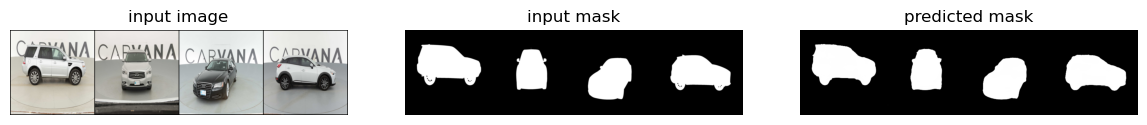

epochs - 41/50 [1018/1018], dice score: 0.9752930901013315, train loss: 0.13676912830831495, val loss: 0.14367186243180186, iou score:0.9565715193748474, train_accuracy:0.994448721408844, valid_accuracy:0.9905533790588379, Recall:0.9960429668426514, Precision:0.9602258801460266, Specificity:0.9890673160552979


100%|██████████| 128/128 [00:21<00:00,  5.95it/s]


epochs - 42/50 [1018/1018], dice score: 0.9328866400755942, train loss: 0.1373179477213174, val loss: 0.1797971745254472, iou score:0.8788264989852905, train_accuracy:0.9940996170043945, valid_accuracy:0.971538782119751, Recall:0.9860805869102478, Precision:0.8899434208869934, Specificity:0.9677106142044067


100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


epochs - 43/50 [1018/1018], dice score: 0.9795630960725248, train loss: 0.137685112830815, val loss: 0.1397631042636931, iou score:0.9661062955856323, train_accuracy:0.99387526512146, valid_accuracy:0.9928061366081238, Recall:0.9727864861488342, Precision:0.9929459691047668, Specificity:0.9981468915939331


100%|██████████| 128/128 [00:20<00:00,  6.18it/s]


epochs - 44/50 [1018/1018], dice score: 0.98115573823452, train loss: 0.1372464720620856, val loss: 0.1385354857193306, iou score:0.9687398672103882, train_accuracy:0.9941096305847168, valid_accuracy:0.9933246970176697, Recall:0.9842686057090759, Precision:0.9839817881584167, Specificity:0.9957239627838135


100%|██████████| 128/128 [00:21<00:00,  5.93it/s]


epochs - 45/50 [1018/1018], dice score: 0.5748500030022115, train loss: 0.13673539061560377, val loss: 0.5009193196892738, iou score:0.406217485666275, train_accuracy:0.9943751096725464, valid_accuracy:0.6902474164962769, Recall:0.9925223588943481, Precision:0.4075203537940979, Specificity:0.6104747653007507


100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


epochs - 46/50 [1018/1018], dice score: 0.9837837344966829, train loss: 0.13640945340362184, val loss: 0.13632850430440158, iou score:0.9747222065925598, train_accuracy:0.9945507049560547, valid_accuracy:0.9946165084838867, Recall:0.9877501130104065, Precision:0.986652135848999, Specificity:0.9964404106140137


100%|██████████| 128/128 [00:21<00:00,  5.92it/s]


epochs - 47/50 [1018/1018], dice score: 0.9657429615035653, train loss: 0.136309625460146, val loss: 0.15173248178325593, iou score:0.939653754234314, train_accuracy:0.9946103692054749, valid_accuracy:0.9865636229515076, Recall:0.9883229732513428, Precision:0.9502100348472595, Specificity:0.9860823154449463


100%|██████████| 128/128 [00:22<00:00,  5.80it/s]


epochs - 48/50 [1018/1018], dice score: 0.9018578641116619, train loss: 0.136320019605586, val loss: 0.20674653281457722, iou score:0.8287834525108337, train_accuracy:0.9946075081825256, valid_accuracy:0.9551130533218384, Recall:0.9951551556587219, Precision:0.832257866859436, Specificity:0.9445788264274597


100%|██████████| 128/128 [00:21<00:00,  5.96it/s]


epochs - 49/50 [1018/1018], dice score: 0.9840604257769883, train loss: 0.13628433799931014, val loss: 0.13605696859303862, iou score:0.9752484560012817, train_accuracy:0.9946316480636597, valid_accuracy:0.9947563409805298, Recall:0.9844823479652405, Precision:0.990477442741394, Specificity:0.9974752068519592


100%|██████████| 128/128 [00:20<00:00,  6.15it/s]

epochs - 50/50 [1018/1018], dice score: 0.9823485030792654, train loss: 0.1362640523225479, val loss: 0.13761511666234583, iou score:0.9715011715888977, train_accuracy:0.9946810007095337, valid_accuracy:0.9938936233520508, Recall:0.9936472773551941, Precision:0.9775733351707458, Specificity:0.9939475655555725
Best Dice Score: 0.9841
Best IoU Score: 0.9752
Best Precision: 0.9957
Best Train Accuracy: 0.9947
Best Valid Accuracy: 0.9948


In [25]:
history = train(model, optimizer, criterion) 

# TEST

In [26]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [27]:
create_dir("new_data/test/image_TransUNET-DILATED/")

In [28]:
import os
import hashlib
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont

In [29]:
font_size = 22
font_path = "/kaggle/input/fontss/Agdasima-Bold.ttf"  # Update the path based on your font file location
font = ImageFont.truetype(font_path, size=font_size)

def test(model, test_dataset_loader, criterion, save_dir):
    model.eval()
    test_loss = 0
    test_iterations = 0
    dice_score_total = 0

    transform = transforms.ToPILImage()
    gap_size = 20  # Adjust the gap size between the images

    with torch.no_grad():
        for idx, data in enumerate(tqdm(test_dataset_loader)):
            test_iterations += 1
            test_img = data['img'].to(device)
            test_mask = data['mask'].to(device)
            threshold = 0.5  # You can adjust this threshold based on your needs
            test_mask1 = (test_mask >= threshold).float()
            
            test_img = test_img.unsqueeze(0)

            with torch.autocast(device_type='cuda'):
                test_output_mask = model(test_img)
                test_loss = criterion(test_output_mask, test_mask)
                dice_score_batch = dice_score(test_output_mask, test_mask)
                dice_score_total += dice_score_batch

                for i in range(test_img.size(0)):
                    img = transform(test_img[i].cpu())
                    mask = transform(test_mask[i].cpu())
                    predicted_mask = transform(test_output_mask[i].cpu())
                    img_width, img_height = img.size
                    combined_img_width = img_width * 3 + gap_size * 2
                    combined_img_height = img_height + gap_size * 2
                    combined_img = Image.new('RGB', (combined_img_width, combined_img_height), color='white')
                    combined_img.paste(img, (gap_size, gap_size))
                    combined_img.paste(mask, (img_width + gap_size * 2, gap_size))
                    combined_img.paste(predicted_mask, (img_width * 2 + gap_size * 3, gap_size))

                    draw = ImageDraw.Draw(combined_img)
                    # Adjust the font size here
                    # font = ImageFont.truetype("arial.ttf", 16)

                    # Get the original image name from the test_dataset_loader
                    original_img_path = test_dataset_loader.dataset.images[idx * test_dataset_loader.batch_size + i]
                    original_img_name = os.path.basename(original_img_path)

                    # Generate a unique hash for the original image name
                    img_name_hash = hashlib.md5(original_img_name.encode()).hexdigest()

                    # Construct the predicted image name using the hash
                    predicted_img_name = f'predicted_{img_name_hash}.png'

                    draw.text((gap_size, 0), "Original Image", fill="black", font=font)
                    draw.text((img_width + gap_size * 2, 0), "Ground Truth Mask", fill="black", font=font)
                    draw.text((img_width * 2 + gap_size * 3, 0), "Predicted Mask", fill="black", font=font)

                    combined_img.save(os.path.join(save_dir, predicted_img_name))

    test_epoch_loss = test_loss / test_iterations
    average_dice_score = dice_score_total / test_iterations

    print('Test loss: {}, Dice score: {}'.format(test_epoch_loss, average_dice_score))

    return test_epoch_loss, average_dice_score

In [46]:
def testA(model, test_dataset_loader, criterion):
    model.eval()
    test_loss = 0
    dice_score_total = 0

    with torch.no_grad():
        for idx, data in enumerate(tqdm(test_dataset_loader)):
            test_img = data['img'].to(device)
            test_mask = data['mask'].to(device)
            threshold = 0.5  # You can adjust this threshold based on your needs
            test_mask1 = (test_mask >= threshold).float()

            with torch.autocast(device_type='cuda'):
                test_output_mask = model(test_img)
                test_loss_batch = criterion(test_output_mask, test_mask)
                test_loss += test_loss_batch.item()

                dice_score_batch = dice_score(test_output_mask, test_mask)
                dice_score_total += dice_score_batch.item()

    test_epoch_loss = test_loss / len(test_dataset_loader)
    average_dice_score = dice_score_total / len(test_dataset_loader)

    print('Test loss: {}, Dice score: {}'.format(test_epoch_loss, average_dice_score))

    return test_epoch_loss, average_dice_score


In [47]:
test_loss, test_accuracy = testA(model, test_dataset_loader, criterion)


100%|██████████| 128/128 [00:21<00:00,  5.84it/s]

Test loss: 0.13710815296508372, Dice score: 0.9823394184932113


# RESULTS

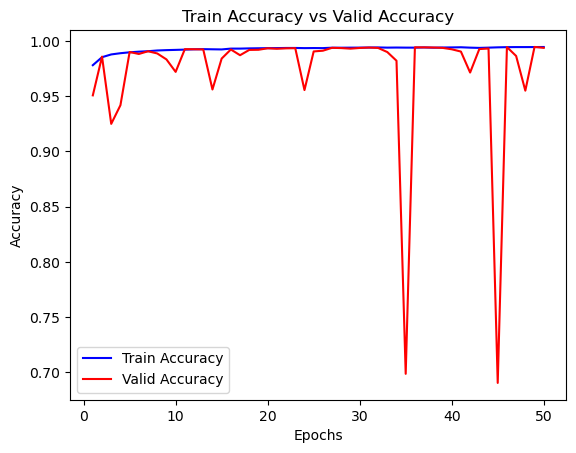

In [48]:
# Accuracy graph
def plot_accuracy(train_acc, valid_acc):
    epochs = range(1, len(train_acc) + 1)
    train_acc_cpu = [acc.cpu().numpy() for acc in train_acc]  # Convert train_acc to CPU
    valid_acc_cpu = [acc.cpu().numpy() for acc in valid_acc]  # Convert valid_acc to CPU
    plt.plot(epochs, train_acc_cpu, 'b', label='Train Accuracy')
    plt.plot(epochs, valid_acc_cpu, 'r', label='Valid Accuracy')
    plt.title('Train Accuracy vs Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
train_acc = history['train_acc']
valid_acc = history['valid_acc']
plot_accuracy(train_acc, valid_acc)

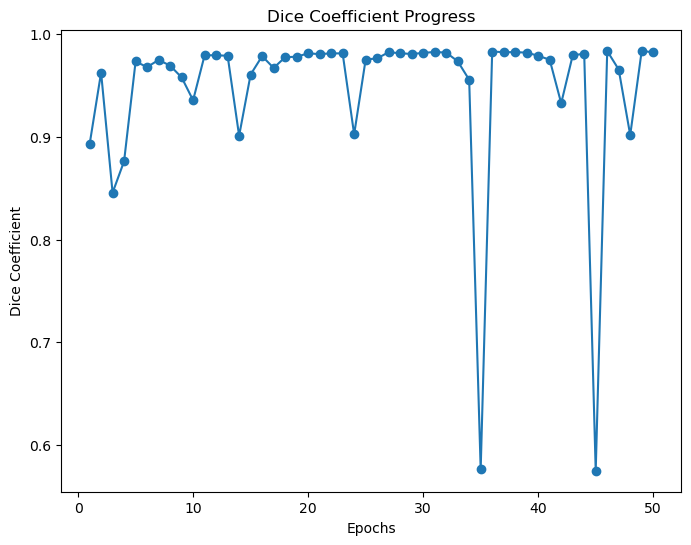

In [49]:
# Plotting the Dice coefficients
epochs = range(1, len(history['dice_scores']) + 1)
dice_scores = history['dice_scores']

plt.figure(figsize=(8, 6))
plt.plot(epochs, dice_scores, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Progress')
plt.show()

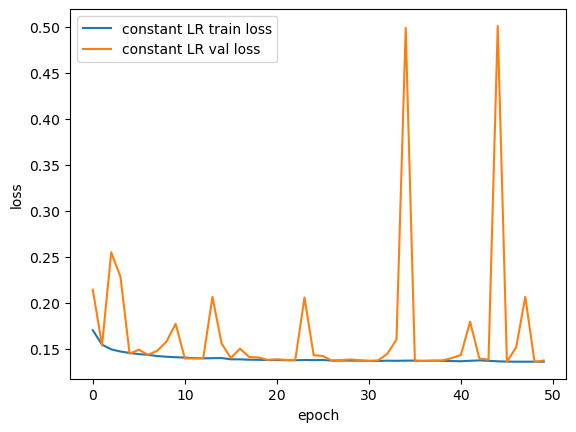

In [50]:
# Loss Graph
plt.plot(history['train_loss'], label='constant LR train loss')
plt.plot(history['valid_loss'], label='constant LR val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# SAVING THE MODEL

In [ ]:
import shutil

# Create a zip file
shutil.make_archive('/kaggle/working/new_data/test/image_TransUNET-DILATED', 'zip', save_dir)


In [ ]:
import torch

# Save the entire model
torch.save(model, 'model_TransUNET-DILATED.pth')

# Save only the model state dictionary
torch.save(model.state_dict(), 'model_state_TransUNET-DILATED.pth')
